In [1]:
%load_ext autoreload
%autoreload 2

# Ising Model Dynamics with Fixed Rank BUG

In [2]:
from copy import deepcopy

from numpy import zeros, eye
from matplotlib.pyplot import subplots, show

from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution
from pytreenet.operators.exact_operators import (exact_ising_hamiltonian,
                                                 exact_local_magnetisation,
                                                 exact_zero_state)
from pytreenet.operators.common_operators import ket_i
from pytreenet.time_evolution.fixed_bug import FixedBUG

## Exact Reference Solution

In [3]:
local_dim = 2
time_step_size = 0.01
final_time = 1
num_sites = 4
coupling = 1
field = 0.75

In [4]:
hamiltonian = exact_ising_hamiltonian(coupling, field, num_sites)
site_ids = [f"Qubit_{i}" for i in range(num_sites)]
operators = exact_local_magnetisation(site_ids)
intital_state = exact_zero_state(num_sites, local_dim)

print("Hamiltonian Shape:", hamiltonian.shape)
print("Operators Shape:", operators[site_ids[0]].shape)
print("Initial State Shape:", intital_state.shape)

Hamiltonian Shape: (16, 16)
Operators Shape: (16, 16)
Initial State Shape: (16,)


In [5]:
exact_evo = ExactTimeEvolution(intital_state,
                               hamiltonian,
                               time_step_size, final_time,
                               operators)

In [6]:
exact_evo.run()

100%|██████████| 101/101 [00:00<00:00, 31201.64it/s]


## Binary TTN

In [7]:
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.core.node import Node
from pytreenet.operators.models import ising_model, local_magnetisation
from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.operators.tensorproduct import TensorProduct

In [8]:
root_tensor = zeros([local_dim**2, local_dim**2, 1],
                    dtype=complex)
root_tensor[0, 0, 0] = 1

mid_tensor = zeros([local_dim**2, local_dim, local_dim, 1],
                    dtype=complex)
mid_tensor[0, 0, 0, 0] = 1

qubit_tensors = zeros([local_dim, local_dim],
                      dtype=complex)
ket_0_state = ket_i(0, local_dim)
qubit_tensors[0, :] = deepcopy(ket_0_state)

print("Root Tensor Shape:", root_tensor.shape)
print("Middle Tensor Shape:", mid_tensor.shape)
print("Qubit Tensor Shape:", qubit_tensors.shape)

binary_ttns = TreeTensorNetworkState()
root_id = "Root"
root_node = Node(identifier=root_id)
binary_ttns.add_root(root_node, root_tensor)
middle_ids = [f"Middle {i}" for i in range(2)]
for i, identifier in enumerate(middle_ids):
    middle_node = Node(identifier=identifier)
    binary_ttns.add_child_to_parent(middle_node,
                                    deepcopy(mid_tensor),
                                    0,
                                    root_id,
                                    i)

qubit_ids = [f"Qubit_{i}" for i in range(num_sites)]
parent_legs = [1,2,1,2]
parent_ids = [middle_ids[0], middle_ids[0], middle_ids[1], middle_ids[1]]
for i, identifier in enumerate(qubit_ids):
    qubit_node = Node(identifier=identifier)
    binary_ttns.add_child_to_parent(qubit_node,
                                    deepcopy(qubit_tensors),
                                    0,
                                    parent_ids[i],
                                    parent_legs[i])

Root Tensor Shape: (4, 4, 1)
Middle Tensor Shape: (4, 2, 2, 1)
Qubit Tensor Shape: (2, 2)


In [9]:
nearest_neighbours = [qubit_ids[i:i+2] for i in range(num_sites-1)]
print("Nearest Neighbours:", nearest_neighbours)
ising_ham = ising_model(nearest_neighbours, field, factor=coupling)
print("Ising Hamiltonian:", ising_ham)
binary_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, binary_ttns)

Nearest Neighbours: [['Qubit_0', 'Qubit_1'], ['Qubit_1', 'Qubit_2'], ['Qubit_2', 'Qubit_3']]
Ising Hamiltonian: [{'Qubit_2': 'mgZ'}, {'Qubit_3': 'mgZ'}, {'Qubit_0': 'mgZ'}, {'Qubit_1': 'mgZ'}, {'Qubit_0': 'mX', 'Qubit_1': 'X'}, {'Qubit_1': 'mX', 'Qubit_2': 'X'}, {'Qubit_2': 'mX', 'Qubit_3': 'X'}]


In [10]:
operators = local_magnetisation(qubit_ids)
operators["energy"] = binary_ttno
operators["norm"] = TensorProduct({qubit_ids[0]: eye(local_dim)})

In [11]:
binary_tree_fixed_bug = FixedBUG(binary_ttns, binary_ttno, time_step_size, final_time, operators)
print(binary_tree_fixed_bug.state.bond_dims())

{('Root', 'Middle 0'): 4, ('Root', 'Middle 1'): 4, ('Middle 0', 'Qubit_0'): 2, ('Middle 0', 'Qubit_1'): 2, ('Middle 1', 'Qubit_2'): 2, ('Middle 1', 'Qubit_3'): 2}


In [12]:
binary_tree_fixed_bug.run()

100%|██████████| 101/101 [00:01<00:00, 79.40it/s]


### Binary Tree: Plotting Results

In [13]:
times = binary_tree_fixed_bug.times()
print("The results are approximately real:", binary_tree_fixed_bug.results_real())

The results are approximately real: True


In [14]:
norm = binary_tree_fixed_bug.operator_result("norm", realise=True)
norm_error = norm - 1

Maximum Error: 8.43769498715119e-15


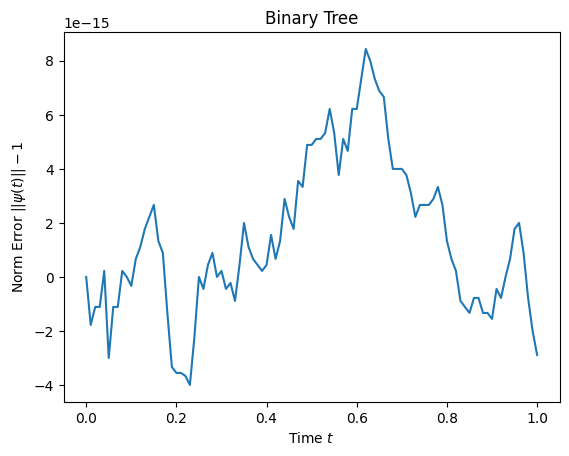

In [15]:
maximum_error = max(abs(norm_error))
print("Maximum Error:", maximum_error)
fig, ax = subplots()
ax.plot(times, norm_error)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Norm Error $||\psi(t)|| - 1$")
ax.set_title("Binary Tree")

show()

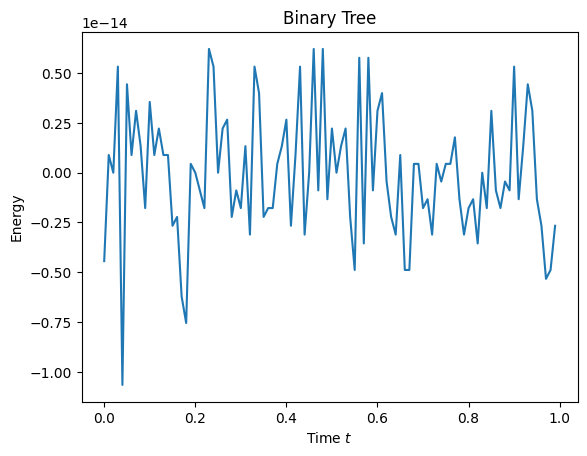

In [16]:
energy = binary_tree_fixed_bug.operator_result("energy", realise=True)
energy_difference = energy[:-1] - energy[1:]

fig, ax = subplots()
ax.plot(times[:-1], energy_difference)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Energy")
ax.set_title("Binary Tree")

show()

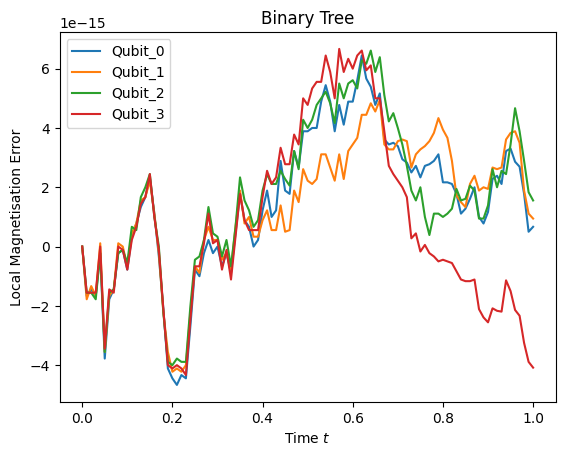

In [17]:
fig, ax = subplots()
for identifier in qubit_ids:
    local_magn = binary_tree_fixed_bug.operator_result(identifier, realise=True)
    exact_local_magn = exact_evo.operator_result(identifier, realise=True)
    magn_error = local_magn - exact_local_magn
    ax.plot(times, magn_error, label=identifier)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Local Magnetisation Error")
ax.legend()
ax.set_title("Binary Tree")

show()

## Tucker Tensor

In [18]:
root_tensor = zeros([local_dim]*num_sites + [1], dtype=complex)
root_tensor[(0,)*num_sites] = 1

qubit_tensors = zeros([local_dim, local_dim], dtype=complex)
qubit_tensors[0, :] = deepcopy(ket_0_state)

print("Root Tensor Shape:", root_tensor.shape)
print("Qubit Tensor Shape:", qubit_tensors.shape)

tucker_ttns = TreeTensorNetworkState()
root_id = "Root"
root_node = Node(identifier=root_id)
tucker_ttns.add_root(root_node, root_tensor)

qubit_ids = [f"Qubit_{i}" for i in range(num_sites)]
for i in range(num_sites):
    qubit_node = Node(identifier=qubit_ids[i])
    tucker_ttns.add_child_to_parent(qubit_node,
                             deepcopy(qubit_tensors),
                             0,
                             root_id,
                             i)

Root Tensor Shape: (2, 2, 2, 2, 1)
Qubit Tensor Shape: (2, 2)


In [19]:
tucker_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, tucker_ttns)

In [20]:
operators = local_magnetisation(qubit_ids)
operators["energy"] = tucker_ttno
operators["norm"] = TensorProduct({qubit_ids[0]: eye(local_dim)})

In [21]:
tucker_fixed_bug = FixedBUG(tucker_ttns, tucker_ttno, time_step_size, final_time, operators)
print(tucker_fixed_bug.state.bond_dims())

{('Root', 'Qubit_0'): 2, ('Root', 'Qubit_1'): 2, ('Root', 'Qubit_2'): 2, ('Root', 'Qubit_3'): 2}


In [22]:
tucker_fixed_bug.run()

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:01<00:00, 95.49it/s]


### Tucker Tree: Plotting Results

In [23]:
times = tucker_fixed_bug.times()
print("The results are approximately real:", tucker_fixed_bug.results_real())

The results are approximately real: True


In [24]:
norm = tucker_fixed_bug.operator_result("norm", realise=True)
norm_error = norm - 1

Maximum Error: 5.773159728050814e-15


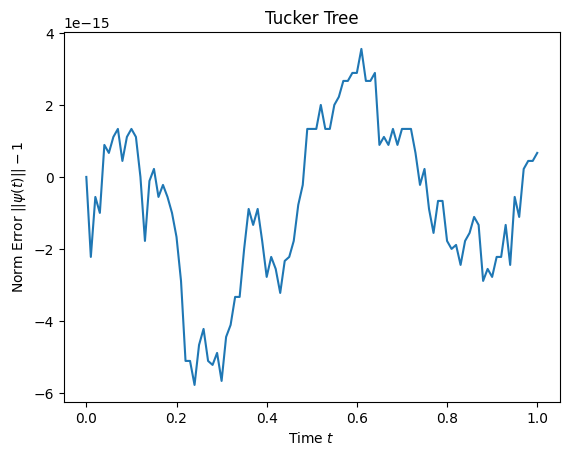

In [25]:
maximum_error = max(abs(norm_error))
print("Maximum Error:", maximum_error)
fig, ax = subplots()
ax.plot(times, norm_error)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Norm Error $||\psi(t)|| - 1$")
ax.set_title("Tucker Tree")

show()

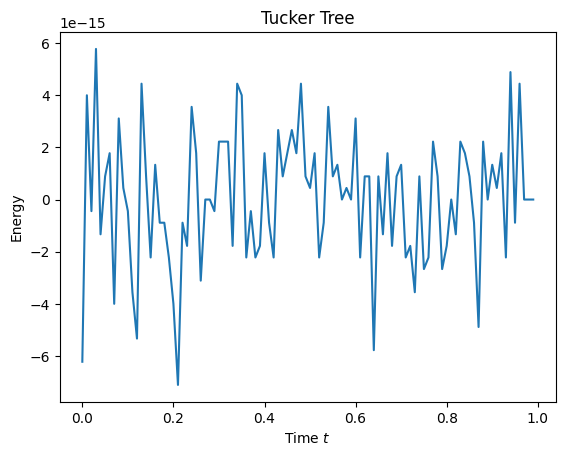

In [26]:
energy = tucker_fixed_bug.operator_result("energy", realise=True)
energy_difference = energy[:-1] - energy[1:]

fig, ax = subplots()
ax.plot(times[:-1], energy_difference)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Energy")
ax.set_title("Tucker Tree")

show()

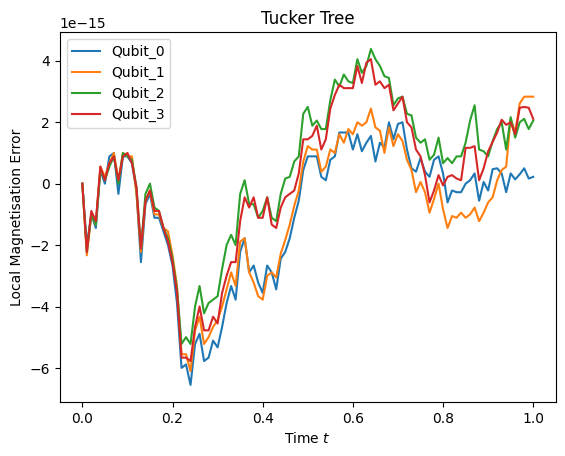

In [27]:
fig, ax = subplots()
for identifier in qubit_ids:
    local_magn = tucker_fixed_bug.operator_result(identifier, realise=True)
    exact_local_magn = exact_evo.operator_result(identifier, realise=True)
    magn_error = local_magn - exact_local_magn
    ax.plot(times, magn_error, label=identifier)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Local Magnetisation Error")
ax.legend()
ax.set_title("Tucker Tree")

show()

## MPS Tree

In [32]:
from pytreenet.special_ttn.mps import MatrixProductState

mps = MatrixProductState.constant_product_state(0, local_dim, num_sites,
                                                node_prefix="Qubit_",
                                                root_site=1,
                                                bond_dimensions=[2,4,2])
mps_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, mps)

In [33]:
operators = local_magnetisation(qubit_ids)
operators["energy"] = mps_ttno
operators["norm"] = TensorProduct({qubit_ids[0]: eye(local_dim)})

In [34]:
mps_fixed_bug = FixedBUG(mps, mps_ttno, time_step_size, final_time, operators)
print(mps_fixed_bug.state.bond_dims())

{('Qubit_1', 'Qubit_0'): 2, ('Qubit_1', 'Qubit_2'): 4, ('Qubit_2', 'Qubit_3'): 2}


In [35]:
mps_fixed_bug.run()

100%|██████████| 101/101 [00:00<00:00, 132.16it/s]


### MPS: Plotting Results

In [36]:
times = mps_fixed_bug.times()
print("The results are approximately real:", mps_fixed_bug.results_real())

The results are approximately real: True


In [37]:
norm = mps_fixed_bug.operator_result("norm", realise=True)
norm_error = norm - 1

Maximum Error: 8.215650382226158e-15


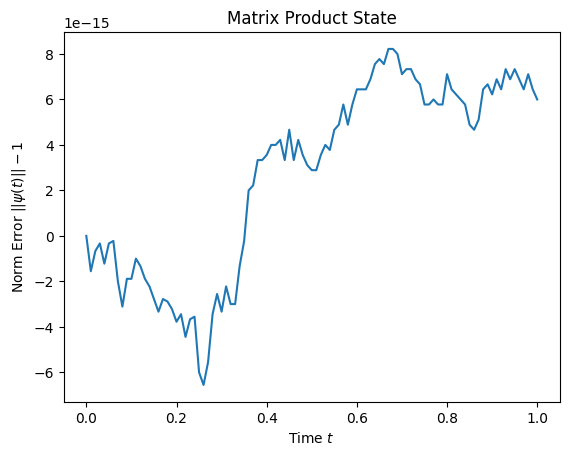

In [39]:
maximum_error = max(abs(norm_error))
print("Maximum Error:", maximum_error)
fig, ax = subplots()
ax.plot(times, norm_error)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Norm Error $||\psi(t)|| - 1$")
ax.set_title("Matrix Product State")

show()

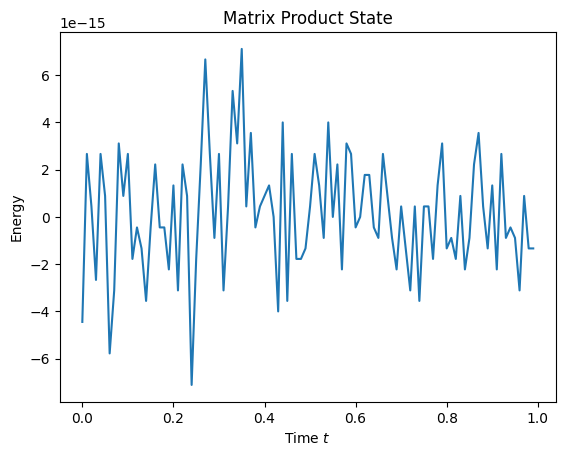

In [40]:
energy = mps_fixed_bug.operator_result("energy", realise=True)
energy_difference = energy[:-1] - energy[1:]

fig, ax = subplots()
ax.plot(times[:-1], energy_difference)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Energy")
ax.set_title("Matrix Product State")

show()

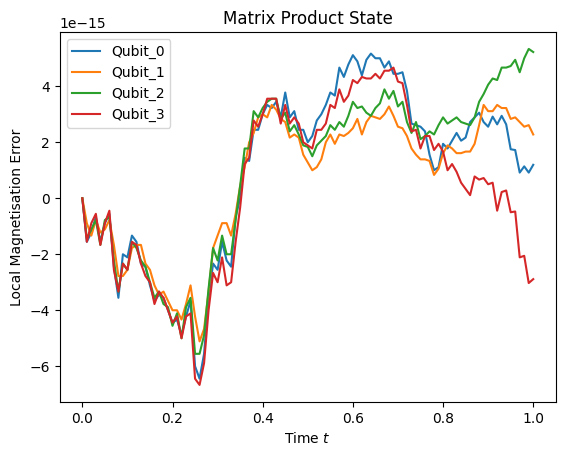

In [41]:
fig, ax = subplots()
for identifier in qubit_ids:
    local_magn = mps_fixed_bug.operator_result(identifier, realise=True)
    exact_local_magn = exact_evo.operator_result(identifier, realise=True)
    magn_error = local_magn - exact_local_magn
    ax.plot(times, magn_error, label=identifier)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Local Magnetisation Error")
ax.legend()
ax.set_title("Matrix Product State")

show()